In [ ]:
#Imports
import pandas as pd
import requests
import matplotlib.pyplot as plt
import json
import numpy as np
from pandas.api.types import is_string_dtype
import os
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import pandas as pd
%matplotlib inline
from IPython.core.pylabtools import figsize
from sklearn.preprocessing import StandardScaler,Normalizer,MinMaxScaler
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
import warnings
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
import statsmodels.api as sm
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
indentity=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/identifiers.csv')

In [ ]:
def get_data(link):
    cy2020_json = requests.get(link)
    cy2020_recs = json.loads(cy2020_json.text)
    df = pd.DataFrame(cy2020_recs)
    return df

In [ ]:
monthly2020=get_data('https://data.cityofnewyork.us/resource/in83-58q5.json?$limit=5000000')
monthly2019=get_data('https://data.cityofnewyork.us/resource/evu4-6zyr.json?$limit=5000000')
monthly2018=get_data('https://data.cityofnewyork.us/resource/njuk-taxk.json?$limit=5000000')

In [ ]:
mon2020=monthly2020.copy()
mon2020.replace('Not Available',np.nan,inplace=True)
mon2020.replace("Insufficient access",np.nan,inplace=True)

In [ ]:
mon2020.head()

,property_id,property_name,parent_property_id,parent_property_name,month,electricity_use_kbtu,natural_gas_use_kbtu
0,7365,1155,Not Applicable: Standalone Property,Not Applicable: Standalone Property,Jan-20,2175731.1,NaN
1,7365,1155,Not Applicable: Standalone Property,Not Applicable: Standalone Property,Feb-20,1902208.9,NaN
2,7365,1155,Not Applicable: Standalone Property,Not Applicable: Standalone Property,Mar-20,1847793.7,NaN
3,7365,1155,Not Applicable: Standalone Property,Not Applicable: Standalone Property,Apr-20,1613573.0,NaN
4,7365,1155,Not Applicable: Standalone Property,Not Applicable: Standalone Property,May-20,1747078.0,NaN


In [ ]:
mon2019=monthly2019.copy()
mon2019.replace('Not Available',np.nan,inplace=True)
mon2019.replace("Insufficient access",np.nan,inplace=True)

In [ ]:
mon2018=monthly2018.copy()
mon2018.replace('Not Available',np.nan,inplace=True)
mon2018.replace("Insufficient access",np.nan,inplace=True)

In [ ]:
mon2020['electricity_use_kbtu'] = pd.to_numeric(mon2020['electricity_use_kbtu'], errors='ignore')
mon2020['natural_gas_use_kbtu'] = pd.to_numeric(mon2020['natural_gas_use_kbtu'], errors='ignore')
mon2019['electricity_use_kbtu'] = pd.to_numeric(mon2019['electricity_use_kbtu'], errors='ignore')
mon2019['natural_gas_use_kbtu'] = pd.to_numeric(mon2019['natural_gas_use_kbtu'], errors='ignore')
mon2018['electricity_use_kbtu'] = pd.to_numeric(mon2018['electricity_use_kbtu'], errors='ignore')
mon2018['natural_gas_use_kbtu'] = pd.to_numeric(mon2018['natural_gas_use_kbtu'], errors='ignore')



In [ ]:
df1=mon2020.loc[mon2020['property_id'].isin(['1416310'])]
df2=mon2019.loc[mon2019['property_id'].isin(['1416310'])]
df3=mon2018.loc[mon2018['property_id'].isin(['1416310'])]

In [ ]:
# Append all the df
#data_tot = pd.concat([df3,df2,df1],ignore_index = True,sort = False)
data_tot = pd.concat([mon2018,mon2019,mon2020],ignore_index = True,sort = False)

In [ ]:
from datetime import datetime
data_tot['month'] = pd.to_datetime(data_tot['month'], format="%b-%y")

In [ ]:
indentity.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
indentity['property_id']=indentity['property_id'].astype('string')
indentity['property_name']=indentity['property_name'].astype('string')
data_tot['property_id']=data_tot['property_id'].astype('string')
data_tot['property_name']=data_tot['property_name'].astype('string')

In [ ]:
indentity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28067 entries, 0 to 28066
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   property_id                28067 non-null  string 
 1   property_name              28067 non-null  string 
 2   postcode                   28067 non-null  object 
 3   largest_property_use_type  25170 non-null  object 
 4   borough                    27086 non-null  object 
 5   longitude                  28067 non-null  float64
 6   latitude                   28067 non-null  float64
dtypes: float64(2), object(3), string(2)
memory usage: 1.5+ MB


In [ ]:
data_tot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979188 entries, 0 to 979187
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   property_id           979188 non-null  string        
 1   property_name         979188 non-null  string        
 2   parent_property_id    979188 non-null  object        
 3   parent_property_name  979188 non-null  object        
 4   month                 979188 non-null  datetime64[ns]
 5   natural_gas_use_kbtu  874000 non-null  float64       
 6   electricity_use_kbtu  949570 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2), string(2)
memory usage: 52.3+ MB


In [ ]:
comp=pd.merge(data_tot, indentity, on=["property_id", "property_name"])

In [ ]:
comp.shape

(832500, 12)

In [ ]:
comp.head()

,property_id,property_name,parent_property_id,parent_property_name,month,natural_gas_use_kbtu,electricity_use_kbtu,postcode,largest_property_use_type,borough,longitude,latitude
0,2691090,Leo Pantas,4985858,Original Campus,2018-01-01,792307.1,97173.8,11205,Lodging/Residential,BROOKLYN,-73.963447,40.690563
1,2691090,Leo Pantas,4985858,Original Campus,2018-02-01,498531.0,96354.9,11205,Lodging/Residential,BROOKLYN,-73.963447,40.690563
2,2691090,Leo Pantas,4985858,Original Campus,2018-03-01,622122.9,96354.9,11205,Lodging/Residential,BROOKLYN,-73.963447,40.690563
3,2691090,Leo Pantas,4985858,Original Campus,2018-04-01,413399.9,104816.6,11205,Lodging/Residential,BROOKLYN,-73.963447,40.690563
4,2691090,Leo Pantas,4985858,Original Campus,2018-05-01,129064.0,115735.0,11205,Lodging/Residential,BROOKLYN,-73.963447,40.690563


In [ ]:
clean=comp.dropna()
clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 663272 entries, 0 to 832499
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   property_id                663272 non-null  string        
 1   property_name              663272 non-null  string        
 2   parent_property_id         663272 non-null  object        
 3   parent_property_name       663272 non-null  object        
 4   month                      663272 non-null  datetime64[ns]
 5   natural_gas_use_kbtu       663272 non-null  float64       
 6   electricity_use_kbtu       663272 non-null  float64       
 7   postcode                   663272 non-null  object        
 8   largest_property_use_type  663272 non-null  object        
 9   borough                    663272 non-null  object        
 10  longitude                  663272 non-null  float64       
 11  latitude                   663272 non-null  float64 

In [ ]:
res=clean[clean['largest_property_use_type']=='Lodging/Residential']
war=clean[clean['largest_property_use_type']=='Warehouse/Storage']
off=clean[clean['largest_property_use_type']=='Office']

In [ ]:
res.groupby(['borough']).count()

,property_id,property_name,parent_property_id,parent_property_name,month,natural_gas_use_kbtu,electricity_use_kbtu,postcode,largest_property_use_type,longitude,latitude
borough,,,,,,,,,,,
BRONX,119686,119686,119686,119686,119686,119686,119686,119686,119686,119686,119686
BROOKLYN,125252,125252,125252,125252,125252,125252,125252,125252,125252,125252,125252
MANHATTAN,213486,213486,213486,213486,213486,213486,213486,213486,213486,213486,213486
QUEENS,76178,76178,76178,76178,76178,76178,76178,76178,76178,76178,76178
STATEN IS,3370,3370,3370,3370,3370,3370,3370,3370,3370,3370,3370


In [ ]:
war.groupby(['borough']).count()

,property_id,property_name,parent_property_id,parent_property_name,month,natural_gas_use_kbtu,electricity_use_kbtu,postcode,largest_property_use_type,longitude,latitude
borough,,,,,,,,,,,
BRONX,1949,1949,1949,1949,1949,1949,1949,1949,1949,1949,1949
BROOKLYN,4459,4459,4459,4459,4459,4459,4459,4459,4459,4459,4459
MANHATTAN,699,699,699,699,699,699,699,699,699,699,699
QUEENS,6006,6006,6006,6006,6006,6006,6006,6006,6006,6006,6006
STATEN IS,447,447,447,447,447,447,447,447,447,447,447


In [ ]:
off.groupby(['borough']).count()

,property_id,property_name,parent_property_id,parent_property_name,month,natural_gas_use_kbtu,electricity_use_kbtu,postcode,largest_property_use_type,longitude,latitude
borough,,,,,,,,,,,
BRONX,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775
BROOKLYN,5871,5871,5871,5871,5871,5871,5871,5871,5871,5871,5871
MANHATTAN,36722,36722,36722,36722,36722,36722,36722,36722,36722,36722,36722
QUEENS,6114,6114,6114,6114,6114,6114,6114,6114,6114,6114,6114
STATEN IS,1074,1074,1074,1074,1074,1074,1074,1074,1074,1074,1074


In [ ]:
man_off=off[off['borough']=='BROOKLYN']
#man_off_predict1=man_off.iloc[36254:,:]

In [ ]:
man_off_train=man_off.iloc[:36254,:]

In [ ]:
melt_elect=man_off[['month','property_id','electricity_use_kbtu']].sort_values(['month','property_id'])
melt_gas=man_off[['month','property_id','natural_gas_use_kbtu']].sort_values(['month','property_id'])

In [ ]:
melt_elect.head()

,month,property_id,electricity_use_kbtu
22140,2018-01-01,1836480,308444.8
22536,2018-01-01,1836506,46403.2
25704,2018-01-01,1836745,141529.8
27108,2018-01-01,1836866,1342963.1
27432,2018-01-01,1836897,26204.2


In [ ]:
melt_elect_train=melt_elect[melt_elect['month']<'2020-01-01'].copy()
melt_elect_test=melt_elect[melt_elect['month']>='2020-01-01'].copy()
melt_gas_train=melt_gas[melt_gas['month']<'2020-01-01'].copy()
melt_gas_test=melt_gas[melt_gas['month']>='2020-01-01'].copy()

In [ ]:
melt_elect_train['electricity_use_next_month']=melt_elect_train.groupby('property_id')['electricity_use_kbtu'].shift(-1)
melt_elect_test['electricity_use_next_month']=melt_elect_test.groupby('property_id')['electricity_use_kbtu'].shift(-1)

melt_gas_train['gas_use_next_month']=melt_gas_train.groupby('property_id')['natural_gas_use_kbtu'].shift(-1)
melt_gas_test['electricity_use_next_month']=melt_gas_test.groupby('property_id')['natural_gas_use_kbtu'].shift(-1)


In [ ]:
melt_elect_train=melt_elect_train.dropna()
melt_gas_train=melt_gas_train.dropna()

In [ ]:
#compute lag
melt_elect_train['lag_1']=melt_elect_train.groupby('property_id')['electricity_use_kbtu'].shift(1)
melt_elect_test['lag_1']=melt_elect_test.groupby('property_id')['electricity_use_kbtu'].shift(1)

melt_gas_train['lag_1']=melt_gas_train.groupby('property_id')['natural_gas_use_kbtu'].shift(1)
melt_gas_test['lag_1']=melt_gas_test.groupby('property_id')['natural_gas_use_kbtu'].shift(1)


In [ ]:
#compute diff
melt_elect_train['diff_1']=melt_elect_train.groupby('property_id')['electricity_use_kbtu'].diff(1)
melt_elect_test['diff_1']=melt_elect_test.groupby('property_id')['electricity_use_kbtu'].diff(1)

melt_gas_train['diff_1']=melt_gas_train.groupby('property_id')['natural_gas_use_kbtu'].diff(1)
melt_gas_test['diff_1']=melt_gas_test.groupby('property_id')['natural_gas_use_kbtu'].diff(1)

In [ ]:
#stats
melt_elect_train['mean_4']=melt_elect_train.groupby('property_id')['electricity_use_kbtu'].rolling(4).mean().reset_index(level=0, drop=True)
melt_elect_test['mean_4']=melt_elect_test.groupby('property_id')['electricity_use_kbtu'].rolling(4).mean().reset_index(level=0, drop=True)

melt_gas_train['mean_4']=melt_gas_train.groupby('property_id')['natural_gas_use_kbtu'].rolling(4).mean().reset_index(level=0, drop=True)
melt_gas_test['mean_4']=melt_gas_test.groupby('property_id')['natural_gas_use_kbtu'].rolling(4).mean().reset_index(level=0, drop=True)

In [ ]:
#evaluation
def mape(y_true,y_pred):
  ape=np.abs((y_true-y_pred)/y_true)
  ape[-np.isfinite(ape)]=1
  return np.mean(ape)

def wmape(y_true,y_pred):
  return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

In [ ]:
#baseline that next months use will be the same as previous
y_pred=melt_elect_train['electricity_use_kbtu']
y_true=melt_elect_train['electricity_use_next_month']

In [ ]:
mape(y_true,y_pred)

0.15266572848677573

In [ ]:
wmape(y_true,y_pred)

0.11077752718893058

In [ ]:
melt_elect_train.head()

,month,property_id,electricity_use_kbtu,electricity_use_next_month,lag_1,diff_1,mean_4
22140,2018-01-01,1836480,308444.8,327552.1,NaN,NaN,NaN
22536,2018-01-01,1836506,46403.2,40944.0,NaN,NaN,NaN
25704,2018-01-01,1836745,141529.8,138663.7,NaN,NaN,NaN
27108,2018-01-01,1836866,1342963.1,1383907.3,NaN,NaN,NaN
27432,2018-01-01,1836897,26204.2,25112.3,NaN,NaN,NaN


In [ ]:
features=['electricity_use_kbtu','lag_1','diff_1','mean_4']

In [ ]:
melt_elect_test.shape

(2496, 7)

In [ ]:
imputer=SimpleImputer()
Xtr=imputer.fit_transform(melt_elect_train[features])
ytr=melt_elect_train['electricity_use_next_month']

md1=RandomForestRegressor()
md1.fit(Xtr,ytr)

RandomForestRegressor()

In [ ]:
Xtest=imputer.transform(melt_elect_test[features])
ytest=melt_elect_test['electricity_use_next_month']
p=md1.predict(Xtest)

In [ ]:
mape(ytest,p)

0.2953065781422647

In [ ]:
wmape(ytest,p)

0.12403716617293992

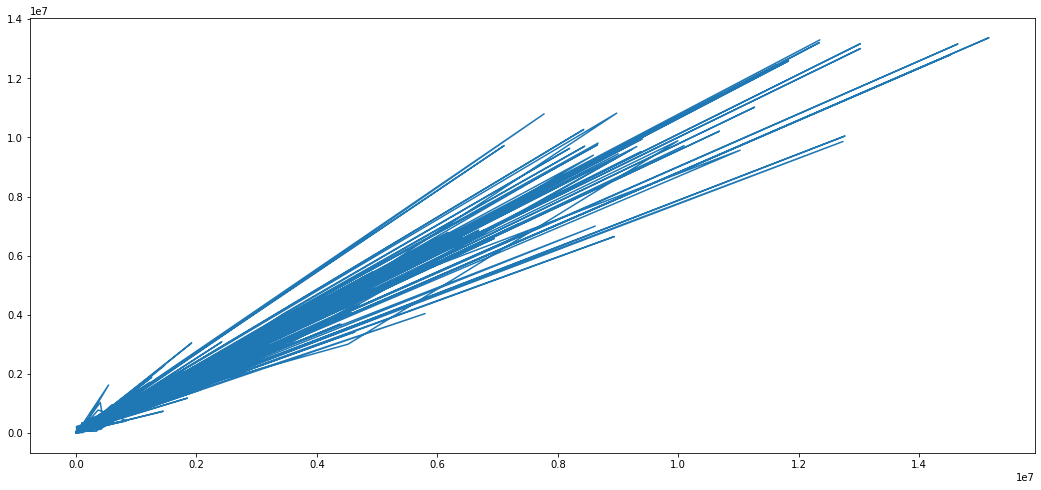

In [ ]:
plt.plot(ytest,p)

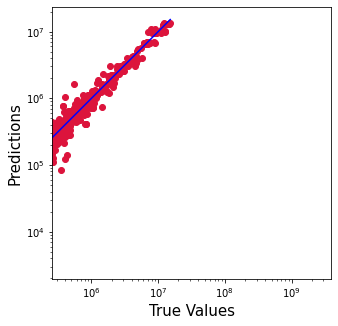

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(ytest, p, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(p), max(ytest))
p2 = min(min(p), min(ytest))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [ ]:
data=man_off[['month','electricity_use_kbtu','natural_gas_use_kbtu']]
data.set_index(data.columns[0],inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5871 entries, 2018-01-01 to 2020-12-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   electricity_use_kbtu  5871 non-null   float64
 1   natural_gas_use_kbtu  5871 non-null   float64
dtypes: float64(2)
memory usage: 137.6 KB


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2cc7f4c110>,
      dtype=object)

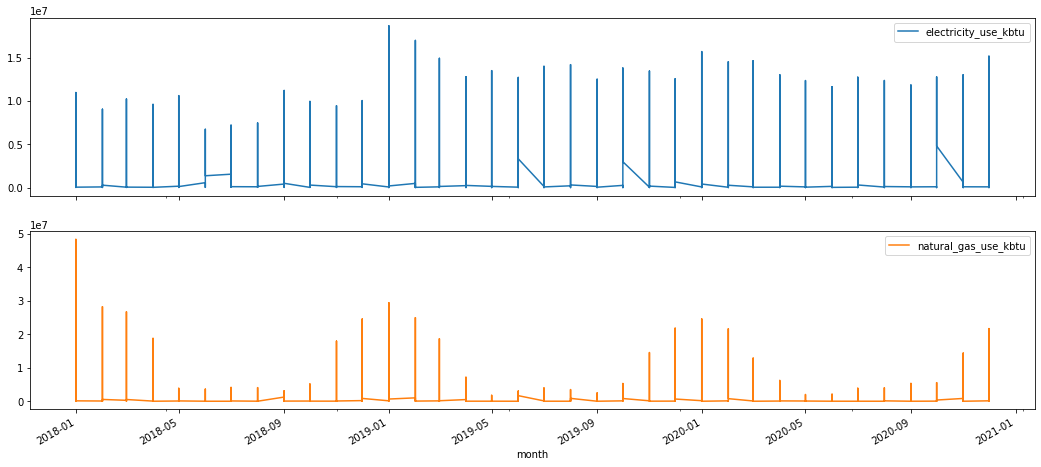

In [ ]:
data[['electricity_use_kbtu','natural_gas_use_kbtu']].plot(subplots=True)

Text(0.5, 1.0, ' Monthly Electricity Usage')

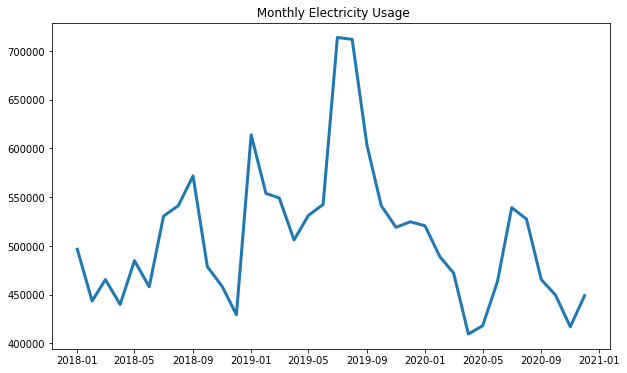

In [ ]:
#create new DataFrame
monthly_OS = pd.DataFrame()

monthly_OS['electricity_use_kbtu'] = data['electricity_use_kbtu'].resample('MS').mean()
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(6)
plt.plot(monthly_OS.index, monthly_OS.electricity_use_kbtu, linewidth=3)
plt.title(' Monthly Electricity Usage')

Text(0.5, 1.0, ' Monthly Gas Usage')

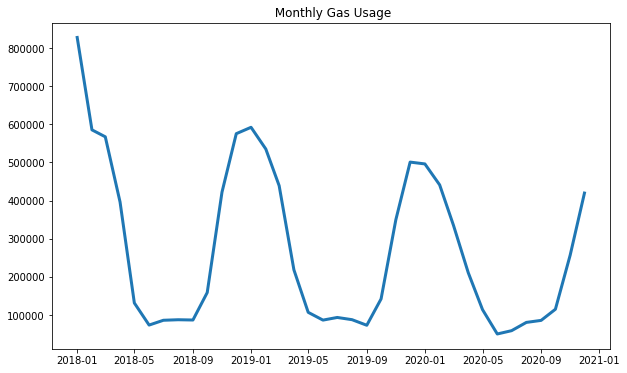

In [ ]:
#create new DataFrame
monthly_OS1 = pd.DataFrame()

monthly_OS1['natural_gas_use_kbtu'] = data['natural_gas_use_kbtu'].resample('MS').mean()
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(6)
plt.plot(monthly_OS1.index, monthly_OS1.natural_gas_use_kbtu, linewidth=3)
plt.title(' Monthly Gas Usage')

In [ ]:
data['year'] = [d.year for d in data.index]
data['month'] = [d.strftime('%b') for d in data.index]
years= data['year'].unique()
years

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([2018, 2019, 2020])

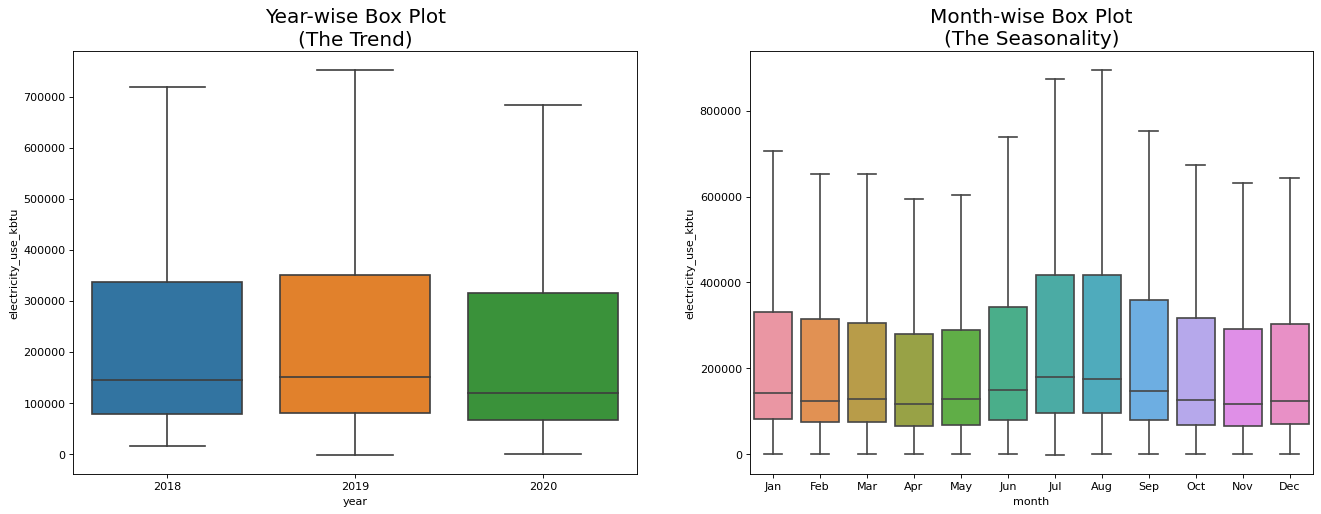

In [ ]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='electricity_use_kbtu', data=data, ax=axes[0],showfliers=False)
sns.boxplot(x='month', y='electricity_use_kbtu', data=data,showfliers=False)

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

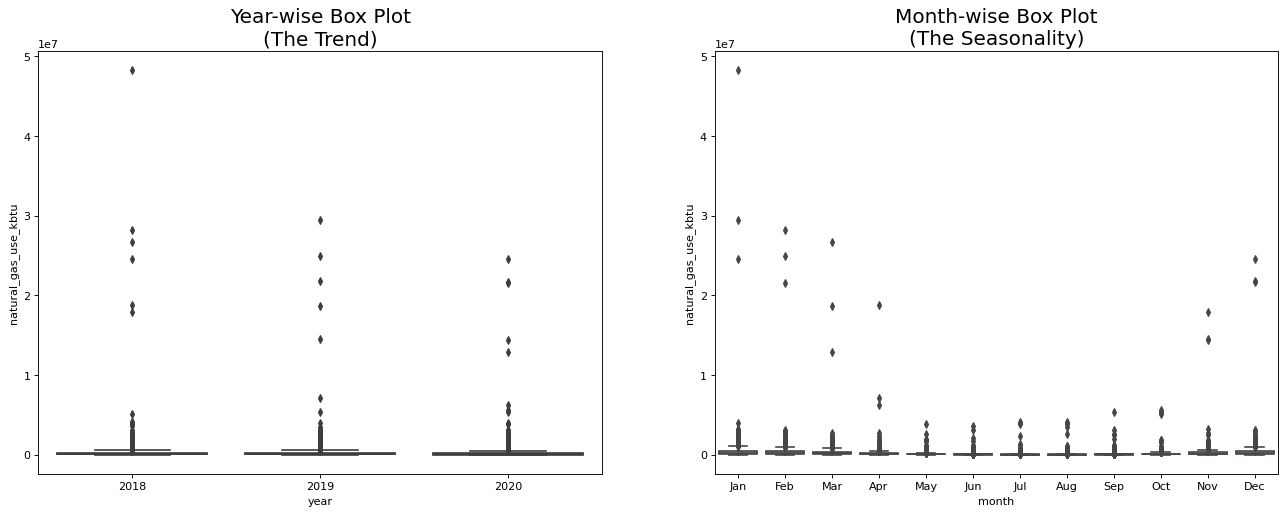

In [ ]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='natural_gas_use_kbtu', data=data, ax=axes[0])
sns.boxplot(x='month', y='natural_gas_use_kbtu', data=data)

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

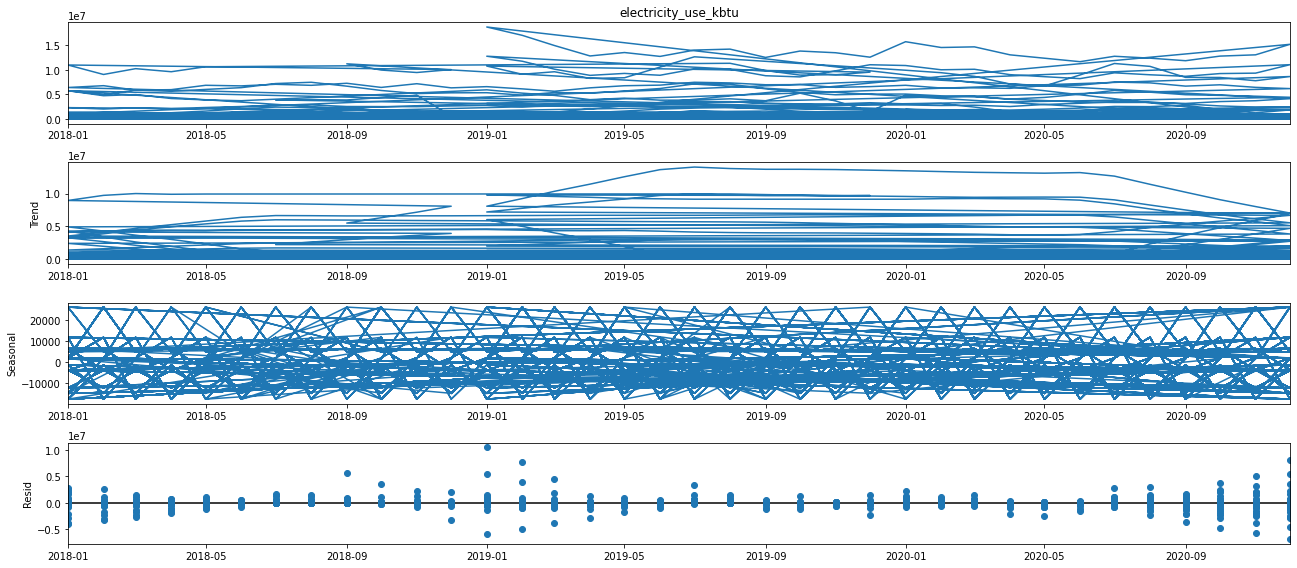

In [ ]:
`

decomposition = seasonal_decompose(data['electricity_use_kbtu'],period=12)
fig = decomposition.plot()
plt.show()

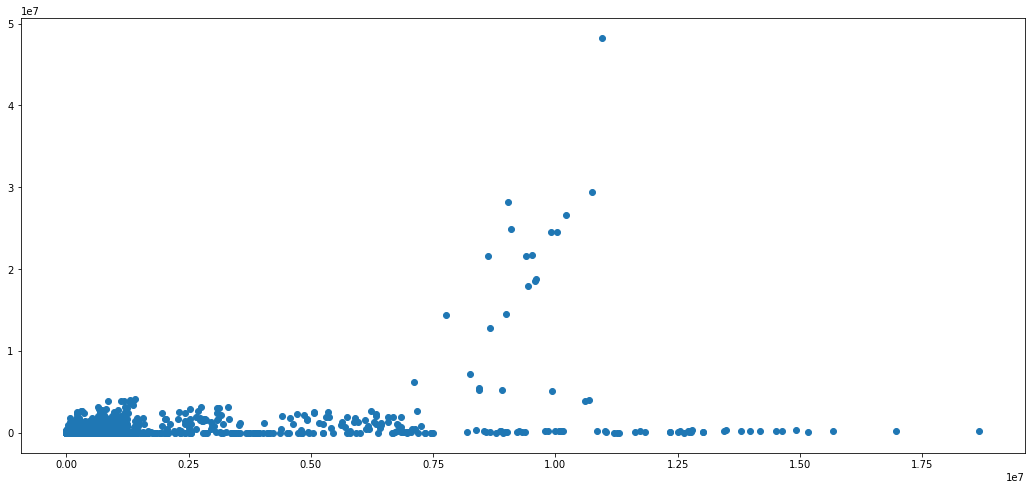

In [ ]:
plt.scatter(data['electricity_use_kbtu'], data['natural_gas_use_kbtu'])


In [ ]:
data.head()

,electricity_use_kbtu,natural_gas_use_kbtu,year,month
month,,,,
2018-01-01,308444.8,585700.0,2018,Jan
2018-02-01,327552.1,633699.9,2018,Feb
2018-03-01,297526.4,573000.0,2018,Mar
2018-04-01,302985.6,371400.0,2018,Apr
2018-05-01,354848.0,29900.0,2018,May


In [ ]:
data1=man_off[['month','electricity_use_kbtu']]
data1.set_index(data1.columns[0],inplace=True)
data2=man_off[['month','natural_gas_use_kbtu']]
data2.set_index(data2.columns[0],inplace=True)

In [ ]:
result1=seasonal_decompose(data['electricity_use_kbtu'])
result2=seasonal_decompose(data['natural_gas_use_kbtu'])
result1.plot();
result2.plot();

ValueError: ignored

In [ ]:
melt_elect_train.shape

(3193, 7)

In [ ]:
data1.shape

(5871, 1)

In [ ]:
data1.iloc[5630]

electricity_use_kbtu    55296.1
Name: 2020-12-01 00:00:00, dtype: float64

In [ ]:
melt_elect=man_off[['month','property_id','electricity_use_kbtu']].sort_values(['month','property_id'])
melt_electid=melt_elect[['property_id']]
melt_elect1=melt_elect[['month','electricity_use_kbtu']]
melt_elect1.set_index(melt_elect1.columns[0],inplace=True)

In [ ]:
train=data1.iloc[:5630]
test=data1.iloc[5630:]


In [ ]:
train.tail()

,electricity_use_kbtu
month,
2020-07-01,84201.0
2020-08-01,82338.5
2020-09-01,66764.6
2020-10-01,55011.9
2020-11-01,54121.8


In [ ]:
scaler=MinMaxScaler()
train_scaled=scaler.fit_transform(train)
test_scaled=scaler.fit_transform(test)

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
###define generator
n=3
n_features=1
generator=TimeseriesGenerator(train_scaled,train_scaled,length=n,batch_size=1)

In [ ]:
X,y=generator[0]
print(f'Given the array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the array: 
[0.01659297 0.01761629 0.01600822]
Predict this y: 
 [[0.0163006]]


In [ ]:
X.shape

(1, 3, 1)

In [ ]:
import plotly.graph_objects as go

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking,Activation


In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:

model = Sequential()
#model.add(LSTM(100, activation='relu', input_shape=(n, n_features)))
model.add(LSTM(100, activation='relu', input_shape=(n, n_features)))
model.add(Dense(1))
model.add(Dropout(0.2))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
 dropout_1 (Dropout)         (None, 1)                 0         
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True,activation='relu', input_shape=(n, n_features)))
model.add(LSTM(64, activation='relu',return_sequences=True))
model.add(LSTM(32, activation='relu',return_sequences=True))
model.add(Dense(3, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 3, 64)             16896     
                                                                 
 lstm_2 (LSTM)               (None, 3, 64)             33024     
                                                                 
 lstm_3 (LSTM)               (None, 3, 32)             12416     
                                                                 
 dense_1 (Dense)             (None, 3, 3)              99        
                                                                 
Total params: 62,435
Trainable params: 62,435
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(generator,epochs=50)

Epoch 1/50
5627/5627 [==============================] - 31s 5ms/step - loss: 0.0012
Epoch 2/50
5627/5627 [==============================] - 30s 5ms/step - loss: 9.2239e-04
Epoch 3/50
5627/5627 [==============================] - 25s 4ms/step - loss: 8.5939e-04
Epoch 4/50
5627/5627 [==============================] - 26s 5ms/step - loss: 8.2361e-04
Epoch 5/50
5627/5627 [==============================] - 26s 5ms/step - loss: 7.8125e-04
Epoch 6/50
5627/5627 [==============================] - 24s 4ms/step - loss: 7.5233e-04
Epoch 7/50
5627/5627 [==============================] - 25s 4ms/step - loss: 7.4718e-04
Epoch 8/50
5627/5627 [==============================] - 24s 4ms/step - loss: 7.9250e-04
Epoch 9/50
5627/5627 [==============================] - 24s 4ms/step - loss: 7.5123e-04
Epoch 10/50
5627/5627 [==============================] - 23s 4ms/step - loss: 7.6395e-04
Epoch 11/50
5627/5627 [==============================] - 22s 4ms/step - loss: 7.4236e-04
Epoch 12/50
5627/5627 [===========

In [ ]:
#last test
model.compile(optimizer='adam', loss='mse')
model.fit(generator,epochs=50)

Epoch 1/50
1188/5627 [=====>........................] - ETA: 48s - loss: 0.0999

KeyboardInterrupt: ignored

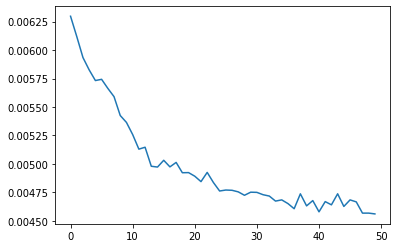

In [ ]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

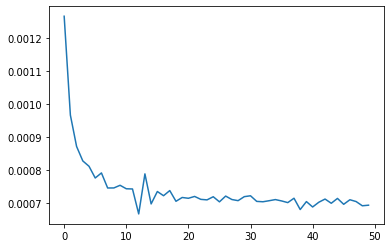

In [ ]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)#elect

In [ ]:
last_train = train_scaled[-3:]
last_train_batch=last_train.reshape((1,n, n_features))

In [ ]:
model.predict(last_train_batch)

array([[0.01767948]], dtype=float32)

In [ ]:
test_scaled[0]

array([0.51281776])

In [ ]:
test_pred=[]
first_eval=train_scaled[-n:]
current_batch=first_eval.reshape((1,n, n_features))

for i in range(len(test)):
  current_pred=model.predict(current_batch)[0]
  test_pred.append(current_pred)
  current_batch=np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [ ]:
#test_pred#elec

In [ ]:
test_pred[:10]

[array([0.0073825], dtype=float32),
 array([0.01050457], dtype=float32),
 array([0.01328018], dtype=float32),
 array([0.01604576], dtype=float32),
 array([0.01863335], dtype=float32),
 array([0.02105342], dtype=float32),
 array([0.02332431], dtype=float32),
 array([0.0254465], dtype=float32),
 array([0.02742498], dtype=float32),
 array([0.02926612], dtype=float32)]

In [ ]:
test.head()

,electricity_use_kbtu
month,
2020-11-01,7773098.2
2020-11-01,316389.8
2020-11-01,241783.8
2020-11-01,52328.0
2020-11-01,81302.2


In [ ]:
true_pred=scaler.inverse_transform(test_pred)

In [ ]:
test['Predictions']=true_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test

,electricity_use_kbtu,Predictions
month,,
2020-12-01,55296.1,7607.127391
2020-01-01,21154.4,8673.144922
2020-02-01,75064.0,9578.117715
2020-03-01,352871.4,10425.261986
2020-04-01,362829.8,11220.492227
...,...,...
2020-08-01,107297.6,21590.801841
2020-09-01,86897.9,21590.801841
2020-10-01,92364.1,21590.801841


In [ ]:
test

,natural_gas_use_kbtu,Predictions
month,,
2020-01-01,184300.0,2.545823e+06
2020-02-01,169800.0,2.411653e+06
2020-03-01,125500.0,2.157466e+06
2020-04-01,95100.0,1.909401e+06
2020-05-01,32000.0,1.721006e+06
...,...,...
2020-08-01,600.0,1.522499e+06
2020-09-01,600.0,1.522498e+06
2020-10-01,1900.0,1.522498e+06


In [ ]:
test.shape

(241, 2)

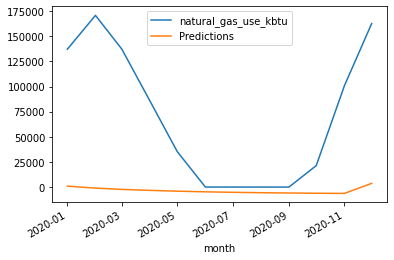

In [ ]:
test[:12].plot()

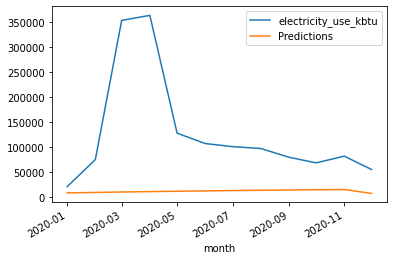

In [ ]:
test[:12].plot()

In [ ]:
#Using facebook prohet
!pip install pystan~=2.14
!pip install fbprophet

In [ ]:
from fbprophet import Prophet
def run_prophet(timeserie):
    model = Prophet(yearly_seasonality=False,daily_seasonality=False)
    model.fit(timeserie)
    forecast = model.make_future_dataframe(periods=90, include_history=False)
    forecast = model.predict(forecast)
    return forecast

In [ ]:
f = run_prophet(melt_elect[2])
f.head()

KeyError: ignored

In [ ]:
melt_elect[2]

KeyError: ignored